In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

In [29]:
data = pd.read_csv("train.csv")
data.head()
ntrain = data.shape[0]
test = pd.read_csv("test.csv")
print(f"data shape {data.shape} ")
print(f"test shape {test.shape} ")

all_data = pd.concat([data, test], axis=0).reset_index(drop=True)

#target_dataは削除
all_data = all_data.drop("Survived", axis=1)
print(f"all_data shape {all_data.shape}")

data shape (891, 12) 
test shape (418, 11) 
all_data shape (1309, 11)


In [30]:
data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [31]:
missing_columns  = (all_data.isnull().sum() /len(all_data)).sort_values(ascending=False)
print(f"The proportion of missing values \n {missing_columns}")

#missing_column内で4割以上欠損値のカラムは削除
try:
    all_data.drop(["Cabin", "Ticket"], axis=1, inplace=True)
except KeyError:
    print("Columns already dropped.")
print(f"all_data shape after removing high missing rate {all_data.shape}")

The proportion of missing values 
 Cabin          0.774637
Age            0.200917
Embarked       0.001528
Fare           0.000764
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
dtype: float64
all_data shape after removing high missing rate (1309, 9)


In [32]:
all_data.isnull().sum().sort_values(ascending=False)

Age            263
Embarked         2
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
dtype: int64

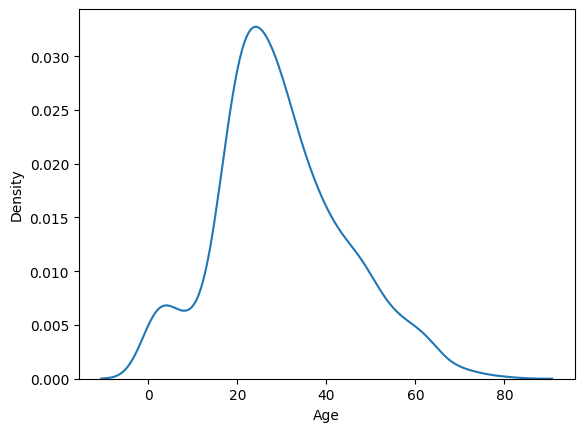

Number of missing valued after filling it 0


In [33]:
#ageカラムの調査
sns.kdeplot(data= all_data, x= "Age")
plt.show()


#Pclassごとだと平均年齢に差異が生じている
all_data["Age"] = all_data.groupby("Pclass")["Age"].transform(lambda x:x.fillna(x.mean()))
print(f"Number of missing valued after filling it {all_data["Age"].isna().sum()}")


all_data["Embarked"] = all_data["Embarked"].fillna(all_data["Embarked"].mode()[0])
all_data["Fare"] = all_data["Fare"].fillna(all_data["Fare"].median())


In [34]:
#新たな特徴量の追加
all_data["FamilySize"] = all_data["SibSp"] + all_data["Parch"] + 1
all_data["IsAlone"] = 1 #yes/1 is alone
all_data["IsAlone"].loc[all_data["FamilySize"] >1] = 0
all_data["Title"] = all_data["Name"].str.split(",", expand=True)[1].str.split(".", expand=True)[0]

all_data["FareBin"] = pd.qcut(all_data["Fare"], 4)
all_data["AgeBin"] = pd.cut(all_data["Age"].astype(int), 5)



C:\Users\thosa\AppData\Local\Temp\ipykernel_19836\2263889525.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_data["IsAlone"].loc[all_data["FamilySize"] >1] = 0
C:\Users\thosa\AppData\Local\Temp\ipykernel_19836\2263889525.py:4: Settin

In [35]:
#レアなtitleの変更
title_names  = (all_data["Title"].value_counts() < 10)

all_data["Title"] = all_data["Title"].apply(lambda x: "Misc" if title_names.loc[x] == True else x)

print(all_data["Title"].value_counts())

Title
 Mr        757
 Miss      260
 Mrs       197
 Master     61
Misc        34
Name: count, dtype: int64


In [36]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
all_data['Sex_Code'] = label.fit_transform(all_data['Sex'])
all_data['Embarked_Code'] = label.fit_transform(all_data['Embarked'])
all_data['Title_Code'] = label.fit_transform(all_data['Title'])
all_data['AgeBin_Code'] = label.fit_transform(all_data['AgeBin'])
all_data['FareBin_Code'] = label.fit_transform(all_data['FareBin'])

In [37]:
train = all_data[:ntrain][["Sex","Pclass","Embarked","Title","SibSp","Parch","FamilySize","IsAlone"]]
y = data["Survived"]


eda_data = pd.concat([train, y], axis=1)
print(eda_data.columns)

for x in eda_data:
  if eda_data[x].dtype != "float64" and x !="Survived":
    print(f"Survial Correlation by:{x}")
    print(eda_data[[x, "Survived"]].groupby(x).mean())
    print("-"*20, "\n")





Index(['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'FamilySize',
       'IsAlone', 'Survived'],
      dtype='object')
Survial Correlation by:Sex
        Survived
Sex             
female  0.742038
male    0.188908
-------------------- 

Survial Correlation by:Pclass
        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
-------------------- 

Survial Correlation by:Embarked
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009
-------------------- 

Survial Correlation by:Title
         Survived
Title            
 Master  0.575000
 Miss    0.697802
 Mr      0.156673
 Mrs     0.792000
Misc     0.444444
-------------------- 

Survial Correlation by:SibSp
       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000
-------------------- 

Survial Correlation by:Parch
       Survived
Parch          
0      0.343658
1      0.5508

In [38]:

print(f"Data type \n {data.dtypes}")
#カテゴリデータの解析
categorical_data = data.select_dtypes("object")


for column in categorical_data.columns:
  contingency_table = pd.crosstab(data["Survived"], data[column])
  print(column)
  # カイ二乗検定
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  print(f"Chi-square: {chi2}, p-value: {p}")

#これより　Plcass、Sex,embarkと関係があることが分かった

Data type 
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Name
Chi-square: 891.0, p-value: 0.484248151973633
Sex
Chi-square: 260.71702016732104, p-value: 1.1973570627755645e-58
Ticket
Chi-square: 766.5697029458893, p-value: 0.01152729601163775
Cabin
Chi-square: 161.25, p-value: 0.18357354976388165
Embarked
Chi-square: 26.48914983923762, p-value: 1.769922284120912e-06


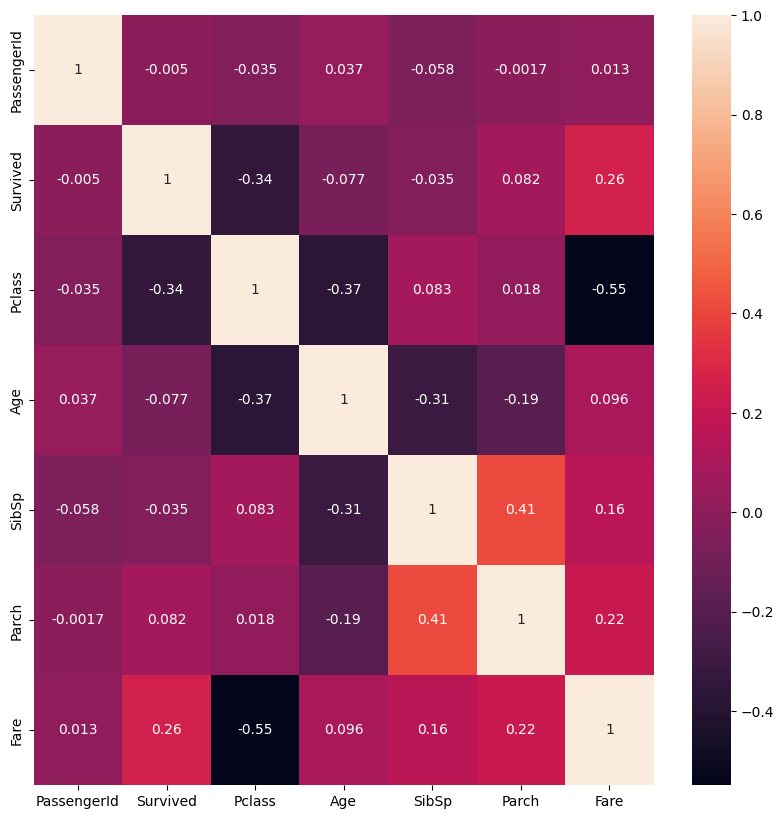

In [39]:
#numerical data 

plt.figure(figsize=(10,10))
numerical_data = data.select_dtypes(np.number)
sns.heatmap(numerical_data.corr(), annot=True)
plt.show()

#これよりageが関係がありそうに思われる

In [54]:
#必要な特徴のみ抽出
extracted_df = all_data[["PassengerId","Pclass","Sex","Embarked", "FamilySize", "Age","IsAlone", "Title","Fare"]]
print(f"extracted_df {extracted_df.shape}")
extracted_df.head()

extracted_df (1309, 9)


,PassengerId,Pclass,Sex,Embarked,FamilySize,Age,IsAlone,Title,Fare
0,1,3,male,S,2,22.0,0,Mr,7.2500
1,2,1,female,C,2,38.0,0,Mrs,71.2833
2,3,3,female,S,1,26.0,1,Miss,7.9250
3,4,1,female,S,2,35.0,0,Mrs,53.1000
4,5,3,male,S,1,35.0,1,Mr,8.0500


In [56]:
#続いて、numericalデータを標準化する
Std = StandardScaler()
extracted_df["Age"] = Std.fit_transform(extracted_df[["Age"]])
extracted_df["Fare"] = Std.fit_transform(extracted_df[["Fare"]])
extracted_df.head()


C:\Users\thosa\AppData\Local\Temp\ipykernel_19836\2243020453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_df["Age"] = Std.fit_transform(extracted_df[["Age"]])
C:\Users\thosa\AppData\Local\Temp\ipykernel_19836\2243020453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_df["Fare"] = Std.fit_transform(extracted_df[["Fare"]])


,PassengerId,Pclass,Sex,Embarked,FamilySize,Age,IsAlone,Title,Fare
0,1,3,male,S,2,-0.559957,0,Mr,-0.503291
1,2,1,female,C,2,0.659292,0,Mrs,0.734744
2,3,3,female,S,1,-0.255145,1,Miss,-0.490240
3,4,1,female,S,2,0.430683,0,Mrs,0.383183
4,5,3,male,S,1,0.430683,1,Mr,-0.487824


In [57]:
#ダミー変数化
extracted_df = pd.get_dummies(data=extracted_df, columns=["Sex","Embarked","Title"])
extracted_df.head()

,PassengerId,Pclass,FamilySize,Age,IsAlone,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,1,3,2,-0.559957,0,-0.503291,False,True,False,False,True,False,False,True,False,False
1,2,1,2,0.659292,0,0.734744,True,False,True,False,False,False,False,False,True,False
2,3,3,1,-0.255145,1,-0.490240,True,False,False,False,True,False,True,False,False,False
3,4,1,2,0.430683,0,0.383183,True,False,False,False,True,False,False,False,True,False
4,5,3,1,0.430683,1,-0.487824,False,True,False,False,True,False,False,True,False,False


In [58]:
#訓練データとテストデータに分ける
train = extracted_df[:ntrain]
y = data["Survived"]
train = train.drop("PassengerId", axis=1)

test = extracted_df[ntrain:]
PassengerId = test["PassengerId"]
test = test.drop("PassengerId", axis=1)

print(f"train shpae {train.shape}")
print(f"test shpae {test.shape}")

train shpae (891, 15)
test shpae (418, 15)


In [59]:
train.head()

,Pclass,FamilySize,Age,IsAlone,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,2,-0.559957,0,-0.503291,False,True,False,False,True,False,False,True,False,False
1,1,2,0.659292,0,0.734744,True,False,True,False,False,False,False,False,True,False
2,3,1,-0.255145,1,-0.490240,True,False,False,False,True,False,True,False,False,False
3,1,2,0.430683,0,0.383183,True,False,False,False,True,False,False,False,True,False
4,3,1,0.430683,1,-0.487824,False,True,False,False,True,False,False,True,False,False


In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model = DecisionTreeClassifier(max_depth=4, random_state=42)
# model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# model = LogisticRegression()
# model = RandomForestClassifier(n_estimators=100, random_state=42)

# k-fold クロスバリデーション (k=5)
scores = cross_val_score(model, train, y, cv=5, scoring='accuracy')

# 結果の出力
print(f"各分割の精度: {scores}")
print(f"平均精度: {scores.mean():.2f}")

各分割の精度: [0.83240223 0.81460674 0.86516854 0.80337079 0.84269663]
平均精度: 0.83


In [84]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

In [94]:
from sklearn.model_selection import GridSearchCV
models = {
    "DecisionTree": (DecisionTreeClassifier(random_state=42), {'max_depth': [3,4, 5, 10], "min_samples_split":[2,3,4,5],"criterion":["gini","entropy"]}),
    "RandomForest": (RandomForestClassifier(random_state=42), {'max_depth': [3,4, 5, 10],'n_estimators': [10, 50, 100]}),
    "Bagging":(BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4), random_state=42), {"n_estimators":[10,50,100]}),
    "Boosting":(GradientBoostingClassifier(random_state=42), {"n_estimators":[10,50,100], "learning_rate":[0.001, 0.01, 0.1]})
}

for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    print(f"Model: {name}")
    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Best Cross-validation Score: {grid_search.best_score_:.2f}")

Model: DecisionTree
  Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
  Best Cross-validation Score: 0.82
Model: RandomForest
  Best Parameters: {'max_depth': 5, 'n_estimators': 10}
  Best Cross-validation Score: 0.84
Model: Bagging
  Best Parameters: {'n_estimators': 50}
  Best Cross-validation Score: 0.82
Model: Boosting
  Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
  Best Cross-validation Score: 0.82


In [95]:
model = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

model.fit(X_train, y_train)
y_pred =model.predict(X_train)
print(f"Final Model Accuracy: {accuracy_score(y_train, y_pred):.2f}")

Final Model Accuracy: 0.85


In [ ]:
y_test_pred = model.predict(test)
# PassengerId と予測結果を DataFrame として作成
compare_result = pd.DataFrame({
    'PassengerId': PassengerId,
    'Survived': y_test_pred
})

# CSV出力
compare_result.to_csv('submission.csv', index=False)